# Multiscalar Segregation Profiles on Urban Street Networks

This notebook examines how different definitions of urban space can affect observed measures of segregation. Using the spatial information theory index (H), we look at how different definitions of the local environment affect values of H for the same study area and population groups. Next, we calculate multiscalar segregation profiles introduced by [Reardon et al](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2831394/) to examine differences between macro and micro segregation. Finally, we examine how these segregation profiles differ when we measure distance in the local environment as a straight line, versus along a pedestrian transport network


**Note** I *highly* recommend installing `pandana` as a multithreaded library following [these instructions](http://udst.github.io/pandana/installation.html). The notebook will still run if you intall from pip or anaconda, but the network computations will take considerably longer

In [1]:
import geopandas as gpd
from pysal.explore.segregation.aspatial import Multi_Information_Theory
from pysal.explore.segregation.spatial import SpatialInformationTheory
from pysal.explore.segregation.network import get_osm_network
from pysal.explore.segregation.util import compute_segregation_profile
from pysal.lib.weights import Queen, Rook, Kernel
from geosnap.data import Community
from geosnap.data.data import get_lehd
from pandana.network import Network
from pysal.viz.splot.pysal.lib import plot_spatial_weights
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

First, we'll get census 2010 data from `geosnap` and project into state plane (so we have planar units for the kernel weights constructor)

In [2]:
dc = Community(source='ltdb', statefips='11')

In [3]:
df = dc.tracts.merge(dc.census[dc.census['year']==2010], on='geoid')

In [4]:
df = df.to_crs(epsg=6487)

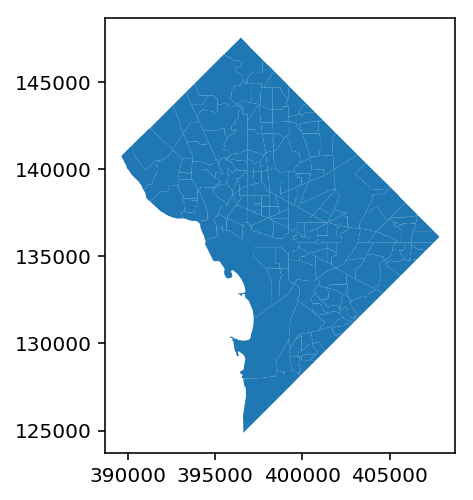

In [5]:
df.plot()

**Note: there are likely to be some nontrivial edge effects since we're truncating the data artificially at the DC border**

kernel weights operate on points, so we'll abstract each polygon to exist at its mathematical center

In [6]:
df_pts = df.copy()
df_pts['geometry'] = df_pts.centroid

We define local environments using spatial weights matrices that encode relationships among our units of observations. Weights matrices can take many forms, so we can choose how to parameterize the environment. Here' we'll examine two contiguity weights, "queen" and "rook", which mean that the local environment of each census tract is the tract itself, and the adjacent tracts sharing either a vertex or side (queen) or just a side (rook). We'll also use kernel distance-based weights. This type of weights matrix considers the local environment to be all tracts that fall within a specified distance of the focal tract, but applies a distance decay function so that tracts further away have a smaller affect than tracts nearby. The network-based weights we'll examine later also work this way. 

Here, we'll create 4 different weights matrices: queen, rook, 1km euclidian kernel, and 2km euclidian kernel

In [7]:
w_queen = Queen.from_dataframe(df)
w_rook = Rook.from_dataframe(df)
w_kernel_1k = Kernel.from_dataframe(df_pts, bandwidth=1000)
w_kernel_2k = Kernel.from_dataframe(df_pts, bandwidth=2000)

/home/knaaptime/anaconda3/lib/python3.7/site-packages/pysal.lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 29 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)
/home/knaaptime/anaconda3/lib/python3.7/site-packages/pysal.lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 2 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)


Text(0.5, 1.0, 'kernel 2k')

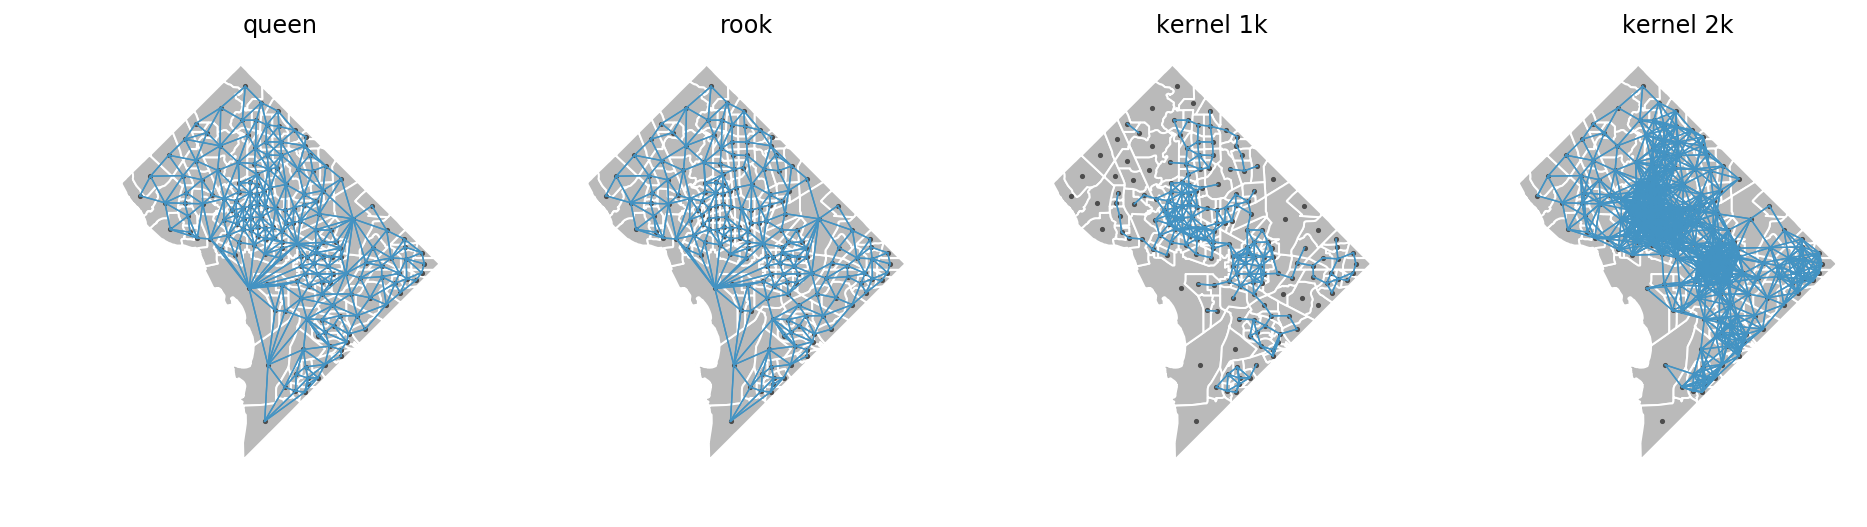

In [8]:
fig, ax = plt.subplots(1,4, figsize=(16,4))

plot_spatial_weights(w_queen, df, ax=ax[0])
ax[0].set_title('queen')

plot_spatial_weights(w_rook, df, ax=ax[1])
ax[1].set_title('rook')

plot_spatial_weights(w_kernel_1k, df, ax=ax[2])
ax[2].set_title('kernel 1k')

plot_spatial_weights(w_kernel_2k, df, ax=ax[3])
ax[3].set_title('kernel 2k')


these plots show us which tracts are considered neighbors with each other using each type of weights matrix. Internally, `segregation` uses the `build_local_environment` function to turn these weights matrices into localized data. The different relationships implied by each matrix result in significantly different local environments as shown below

we'll measure *H* as a function of 4 racial categories, and we'll plot the non-hispanic black population to get a sense for how these local environments vary

In [9]:
groups = ['n_nonhisp_white_persons', 'n_nonhisp_black_persons', 'n_hispanic_persons', 'n_asian_persons']

In [10]:
from pysal.explore.segregation.spatial.spatial_indexes import _build_local_environment

In [11]:
def plot_local_environment(w, ax):

    d = _build_local_environment(df, groups, w)
    d['geometry'] = df.geometry
    d = gpd.GeoDataFrame(d)
    d.plot('n_nonhisp_black_persons', k=6, scheme='quantiles', ax=ax)
    ax.axis('off')


/home/knaaptime/anaconda3/lib/python3.7/site-packages/pysal.lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 29 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)
/home/knaaptime/anaconda3/lib/python3.7/site-packages/pysal.lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 2 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)


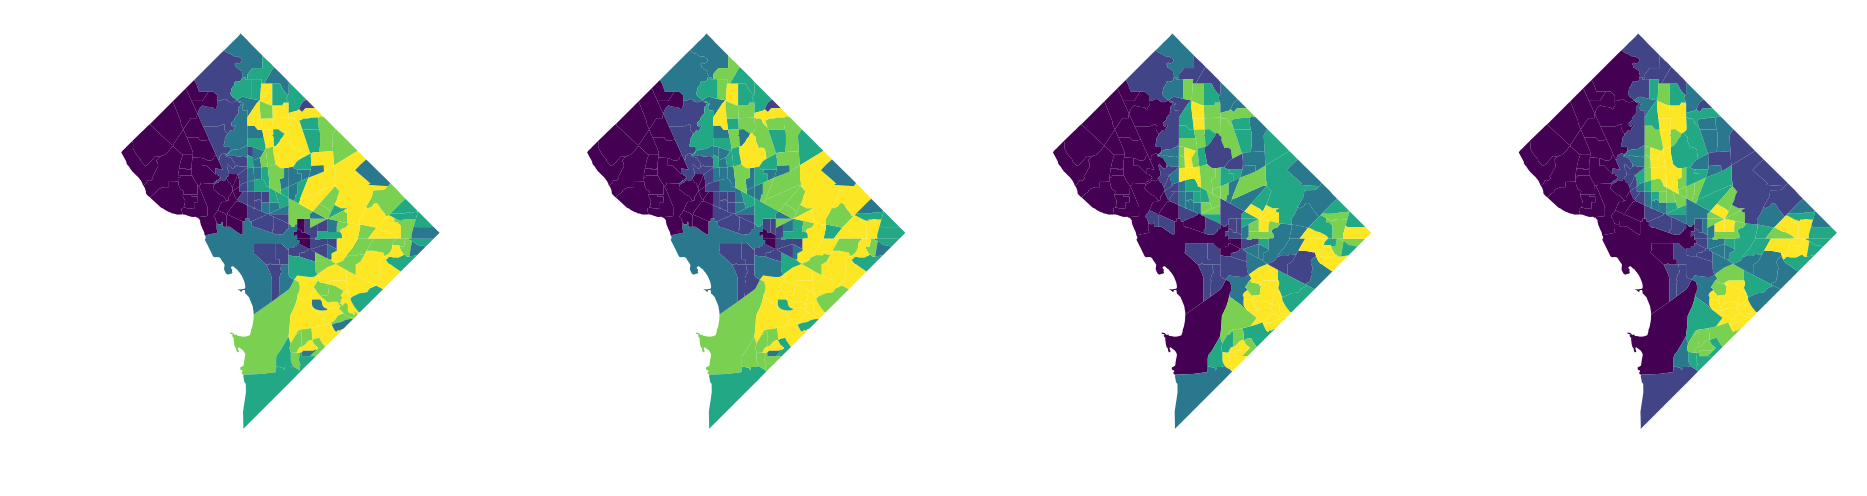

In [12]:
fig, axs = plt.subplots(1,4, figsize=(16,4))

for i, wtype in enumerate([w_queen, w_rook, w_kernel_1k, w_kernel_2k]):
    plot_local_environment(w=wtype, ax=axs[i])

*again, note that this is slightly misleading since in this toy example we're not including data from Maryland and Virigina that would otherwise have a big impact on the "local environment" values displayed here*

And, as we might expect, these different local environments result in different segregation statistics

In [13]:
# aspatial

Multi_Information_Theory(df, groups).statistic

0.3727393704556473

In [14]:
# rook neighborhood

SpatialInformationTheory(df, groups, w=w_rook).statistic

0.2990451657245139

In [15]:
# queen neighborhood

SpatialInformationTheory(df, groups, w=w_queen).statistic

0.27967265953029136

In [16]:
# 1 kilometer kernel distance neighborhood

SpatialInformationTheory(df, groups, w=w_kernel_1k).statistic

/home/knaaptime/anaconda3/lib/python3.7/site-packages/pysal.lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 29 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)


0.2955335586939781

In [17]:
# 2 kilometer kernel distance neighborhood

SpatialInformationTheory(df, groups, w=w_kernel_2k).statistic

/home/knaaptime/anaconda3/lib/python3.7/site-packages/pysal.lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 2 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)


0.22474192583349964

As we increas the distance on the kernel density weights, we get a sense for how segregation varies across scales. Following Reardon et al, We can calculate *H* for a set of increasing distances and plot the results to get a sense of the variation in macro versus micro segregation. `segregation` provides the `compute_segregation_profile` function for that purpose. You pass a dataframe, a list of distances, and a set of groups for which to calculate the statistics 

In [18]:
distances = [1000.,2000.,3000.,4000.,5000.] # note these are floats

In [19]:
euclidian_profile = compute_segregation_profile(df_pts, groups=groups, distances=distances)

/home/knaaptime/anaconda3/lib/python3.7/site-packages/pysal.lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 29 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)
/home/knaaptime/anaconda3/lib/python3.7/site-packages/pysal.lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 29 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)
/home/knaaptime/anaconda3/lib/python3.7/site-packages/pysal.lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 2 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)
/home/knaaptime/anaconda3/lib/python3.7/site-packages/pysal.lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 2 components
  warnings.w

In [20]:
euclidian_profile

{0: 0.3727393704556473,
 1000.0: 0.2955335586939781,
 2000.0: 0.22474192583349964,
 3000.0: 0.1800770024296713,
 4000.0: 0.14551919154094112,
 5000.0: 0.11639339393864294}

The drawback for kernel density weights is that urban space is not experienced in a straight line, but instead conditioned by transport networks. In other words, the local street network can have a big impact on how easily a person may come into contact with others. For that reason, `segregation` can also calculate multiscalar segregation profiles using street network distance. We include the `get_osm_network` function for downloading street network data from OpenStreetMap

In [21]:
# convert back to lat/long and get an OSM street network

df = df.to_crs(epsg=4326)

note it can take awhile to download a street network, so you can save and read it back in using pandana

In [22]:
#net = get_osm_network(df)

#net.save_hdf5('dc_network.h5')

In [23]:
net = Network.from_hdf5('dc_network.h5')

In [24]:
network_linear_profile = compute_segregation_profile(df_pts, groups=groups, network=net, distances=distances)

In [25]:
network_exponential_profile = compute_segregation_profile(df_pts, groups=groups, network=net, distances=distances, decay='exp', precompute=False)
# we're using the same network as before, so no need to precompute again

In [26]:
import matplotlib.pyplot as plt

We now have three different segregation profiles:

  - an exponential kernel in euclidian space
  - an exponential kernel in network space
  - a linear kernel in network space
  
lets plot all three of them and examine the differences

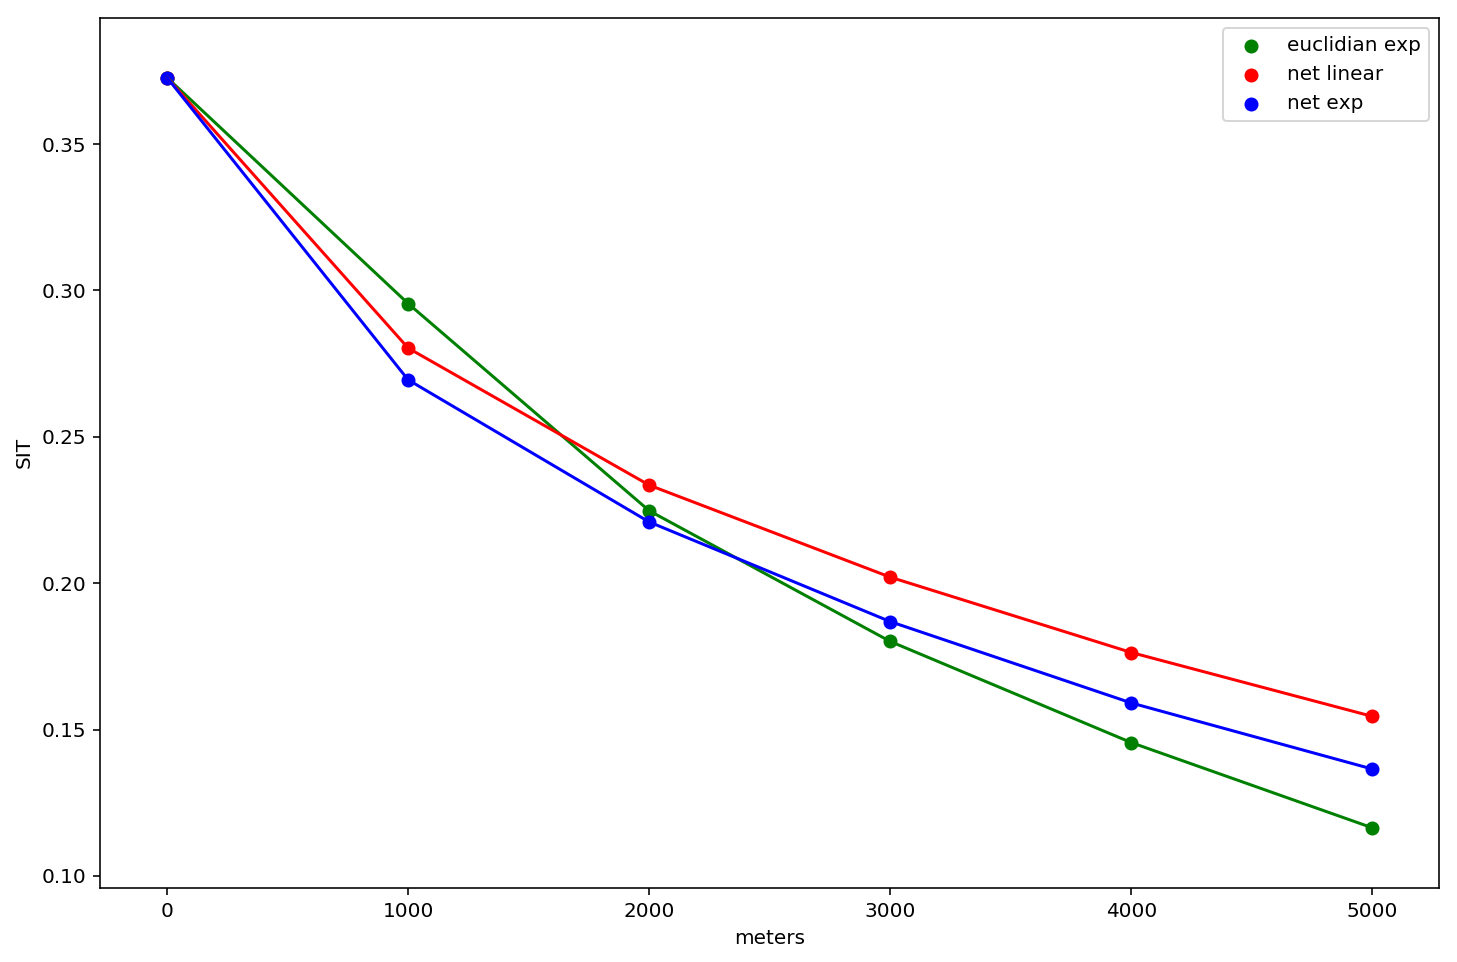

In [27]:
fig, ax = plt.subplots(figsize=(12,8))

ax.scatter(euclidian_profile.keys(), euclidian_profile.values(), c='green', label='euclidian exp')
ax.plot(euclidian_profile.keys(), euclidian_profile.values(), c='green')

ax.scatter(network_linear_profile.keys(), network_linear_profile.values(), c='red', label='net linear')
ax.plot(network_linear_profile.keys(), network_linear_profile.values(), c='red')

ax.scatter(network_exponential_profile.keys(), network_exponential_profile.values(), c='blue', label='net exp')
ax.plot(network_exponential_profile.keys(), network_exponential_profile.values(), c='blue')

plt.xlabel('meters')
plt.ylabel('SIT')

plt.legend()
plt.show()

These results are interesting and show that measured levels of segregation differ according to the analyst's operationalization of space/distance. In general, the network kernels tend to estimate higher levels of segregation, and the euclidian distance has the steepest slope

## Multiscalar Segregation Profiles for Residential and Workplace Areas
### with Block-Level Data

Here, we'll examine how segregation profiles vary by time of day by calculating multiscalar measures for both workplace populations (i.e. daytime) and residential populations (i.e. night time). We'll use more detailed block-level data from LEHD, and we will compare how the profiles differ when we measure using network distance, but weight further observations using a linear decay function versus an exponential decay.

Again, we'll read in the data, convert to a point representation, and project into state plane for our calculations. Well use the `get_lehd` convenience function from `geosnap` to quickly collect block-level attributes for workplace and residential populations

In [28]:
# you can download this file here: https://www2.census.gov/geo/tiger/TIGER2018/TABBLOCK/tl_2018_11_tabblock10.zip

blks = gpd.read_file('zip://tl_2018_11_tabblock10.zip')

In [29]:
blks['geometry'] = blks.centroid

In [30]:
blks = blks.to_crs(epsg=6487)

In [31]:
# we need both workplace area characteristics (wac) and residence area characteristics (rac)

de_wac = get_lehd('wac', state='dc', year='2015')
de_rac = get_lehd('rac', state='dc', year='2015')

In [32]:
# https://lehd.ces.census.gov/data/lodes/LODES7/LODESTechDoc7.3.pdf
# white = CR01
# black = CR02
# asian = CR04
# hispanic = CT02 - guessing these arent exclusive, 

# lets just do white-black in this case

groups_lehd = ['CR01', 'CR02']

In [33]:
blks_wac = blks.merge(de_wac, left_on='GEOID10', right_index=True)
blks_rac = blks.merge(de_rac, left_on='GEOID10', right_index=True)

In [34]:
rac_net = compute_segregation_profile(blks_rac, distances=distances, groups=groups_lehd, network=net, precompute=False)
wac_net = compute_segregation_profile(blks_wac, distances=distances, groups=groups_lehd, network=net, precompute=False)

In [35]:
rac_net_exp = compute_segregation_profile(blks_rac, distances=distances, groups=groups_lehd, network=net, decay='exp', precompute=False)
wac_net_exp = compute_segregation_profile(blks_wac, distances=distances, groups=groups_lehd, network=net, decay='exp', precompute=False)

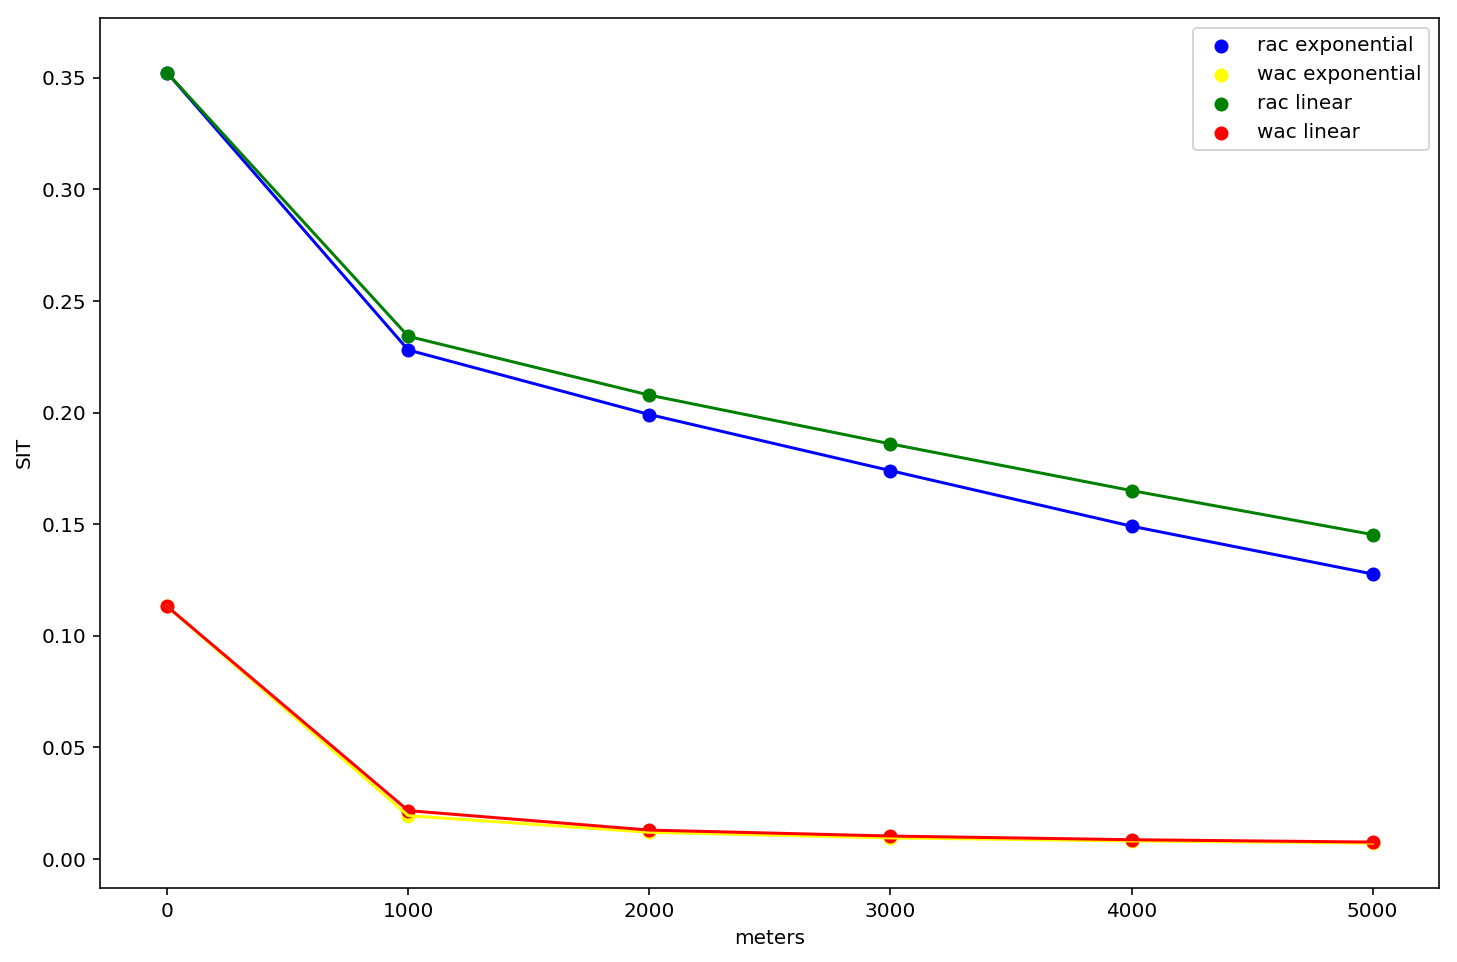

In [36]:
fig, ax = plt.subplots(figsize=(12,8))

ax.scatter(rac_net_exp.keys(), rac_net_exp.values(), c='blue', label='rac exponential')
ax.plot(rac_net_exp.keys(), rac_net_exp.values(), c='blue')

ax.scatter(wac_net_exp.keys(), wac_net_exp.values(), c='yellow', label='wac exponential')
ax.plot(wac_net_exp.keys(), wac_net_exp.values(), c='yellow')

ax.scatter(rac_net.keys(), rac_net.values(), c='green', label='rac linear')
ax.plot(rac_net.keys(), rac_net.values(), c='green')

ax.scatter(wac_net.keys(), wac_net.values(), c='red', label='wac linear')
ax.plot(wac_net.keys(), wac_net.values(), c='red')

plt.xlabel('meters')
plt.ylabel('SIT')
plt.legend()
plt.show()

A few things to take in here:

- these curves are significantly different from the tract-based profiles above. 
    - They are different years, different populations, and different aggregation levels, so we expect them to be (but it raises the question *which* of these variables is causing the difference?)
- residential segregation is **so** much larger than workplace segregation
    - in fact, workplace segregation in DC is essentially 0 for environments greater than 1km
- the residential curve falls faster for exponential decay (as we might expect)
- there's almost no discernible differece between workplace areas segregation profiles using different decay types


what might this say about transport equity and spatial mismatch?